In [13]:
import numpy as np
import matplotlib.pyplot as plt
import epidemic_model_classes_numba as epi_mod
from data_loading import LoadData 
from proj_consts import ProjectConsts
import pandas as pd
from scipy.optimize import curve_fit
from PIL import Image
import time
import os

log_path = "../logs/sdumont/log2021-05-12_05-36-22/"

# data_path = open("data_path.txt", "r").read()
# df_brazil_state_cases = pd.read_csv(data_path)

# pop_state_dat = open(f"{ProjectConsts.DATA_PATH}/pop_states.csv", "r").read().split("\n")
# pop_state = {}
# for i in range(len(pop_state_dat)-1):
#     pop_state_dat[i] = pop_state_dat[i].split(", ")
#     pop_state[pop_state_dat[i][0]] = int(pop_state_dat[i][1])

In [14]:
locations = open(r"locationsIN.txt", "r").read().split("\n")[:-1]
# models = open(r"modelsIN.txt", "r").read().split("\n")[:1]
models = ["SEIRD"]#, "SEIHRD", "SEIARD"]
print(locations)
print(models)

['DF']
['SEIRD']


In [15]:
# data = LoadData.getBrazilStateDataFrame(df_brazil_state_cases, locations[0])

In [16]:
n_post = 0
for file in os.listdir(log_path):
    
    if ("Posterior" in file):
        n_post += 1
        
print(n_post)

10


In [17]:
location = locations[0].split(" ")[0]

days_sets = sorted(os.listdir(log_path+"Posterior1/%s/%s/"%(location, models[0])), key=lambda x: int(x.split("_")[0]))[:-1]
n_days = len(days_sets)

days = []

for days_set in days_sets:
    
    days.append(int(days_set.split("_")[0]))

days = np.array(days)

In [18]:
# days = days[days <= 275]
# days_sets = days_sets[:len(days)]
# n_days = len(days_sets)

In [19]:
plt.rcParams.update({'font.size': 22})

last_post = np.zeros((len(models), n_days))

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
        
    params.append(np.zeros((n_post, n_days, model.nparams)))
    
    for post in range(1, n_post+1):
            
        path = log_path+"Posterior%i/%s/%s/" % (post, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):
            
            params[-1][post-1,days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")
            
            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]
            
            for line in range(len(log_file)):
                
                if "Posterior No." in log_file[line] and post == n_post:
                    last_post[model_idx, days_idx] = np.int(log_file[line].split(" ")[-1])
                    
n_post = int(np.max(last_post))
rmsd_train = np.zeros((len(models), n_post, n_days))
rmsd_val= np.zeros((len(models), n_post, n_days))
rmsd_total = np.zeros((len(models), n_post, n_days))

trials = np.zeros((len(models), n_post, n_days))

post_size = np.zeros((len(models), n_days))
tolerance = np.zeros((len(models), n_post, n_days))

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for post in range(1, n_post+1):
            
        path = log_path+"Posterior%i/%s/%s/" % (post, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):
            
            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]
            
            for line in range(len(log_file)):

                if ("RMSD:" in log_file[line]):

                    rmsd_start_line = line
                    
                if ("Number of trials" in log_file[line]):
                    
                    trials[model_idx, post-1, days_idx] = int(log_file[line].split(" ")[-1])
                    
                if "Training window size:" in log_file[line] and post == 1:
                    post_size[model_idx, days_idx] = np.int(log_file[line].split(" ")[-1])
                    
                if "Tolerance" in log_file[line]:
                    tolerance[model_idx, post-1, days_idx] = np.float64(log_file[line].split(" ")[-1])
            
            rmsd_train[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

Text(0, 0.5, 'Window size')

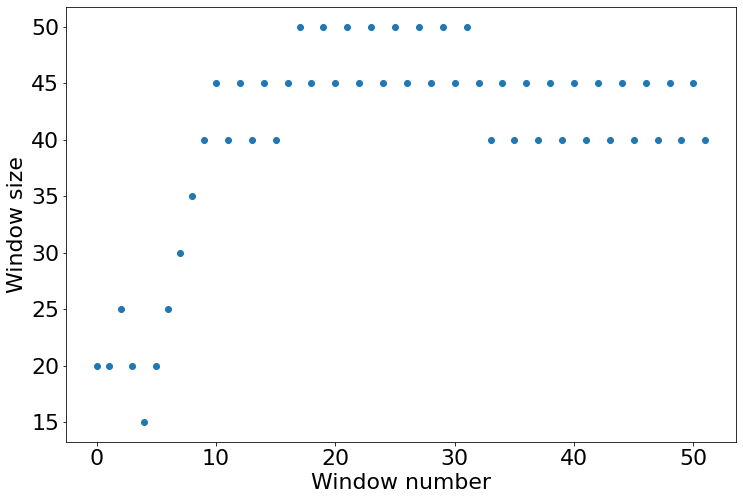

In [20]:
plt.figure(figsize=(12,8))
plt.plot(post_size[0], "o")
plt.xlabel("Window number")
plt.ylabel("Window size")

(0.0, 7.0)

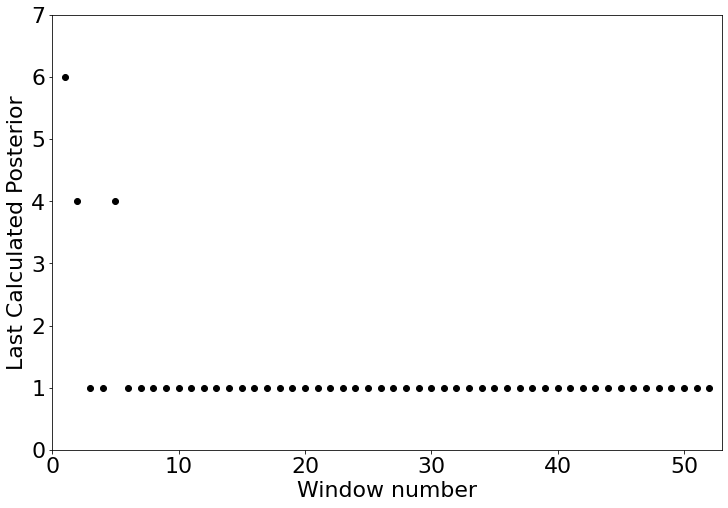

In [21]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(last_post[0])+1), last_post[0], "o", c="k")
plt.xlabel("Window number")
plt.ylabel("Last Calculated Posterior")
plt.xlim(0, len(last_post[0])+1)
plt.ylim(0, np.max(last_post[0])+1)

Text(0, 0.5, 'Tolerance')

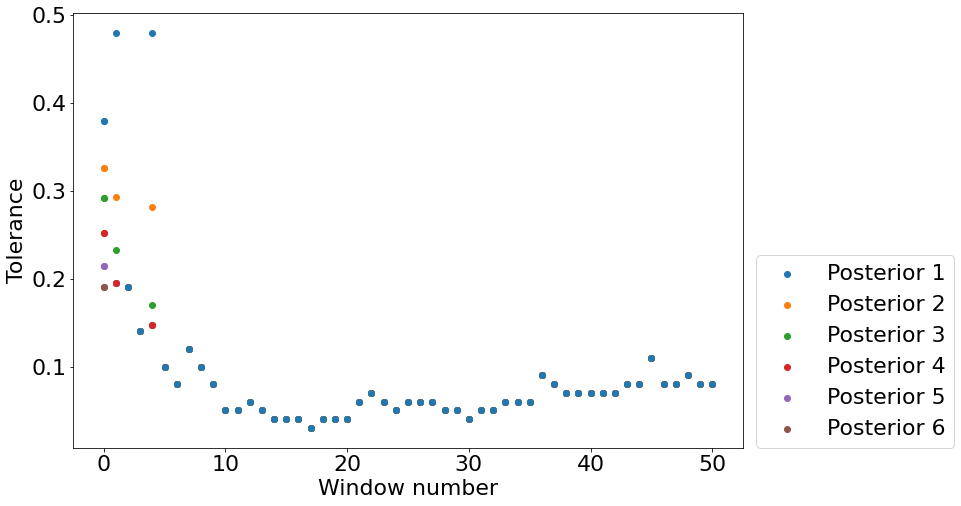

In [22]:
plt.figure(figsize=(12,8))
for i in range(days_idx):
    if i == 0:
        for j in range(n_post):
            plt.scatter(i, tolerance[0,j,i], c=f"C{j}", zorder=-j, label=f"Posterior {j+1}")
    for j in range(n_post):
        plt.scatter(i, tolerance[0,j,i], c=f"C{j}", zorder=-j)
plt.legend(loc=(1.02, 0.))
plt.xlabel("Window number")
plt.ylabel("Tolerance")
# plt.xlim(0, len(last_post[0])+1)
# plt.ylim(0, np.max(last_post[0])+1)

In [23]:
def best_rows_cols(n):
    
    rows = 1
    cols = 1
    
    while (rows*cols < n):
        
        if (rows == cols):
            
            cols += 1
            
        else:
            
            rows += 1
            
    return np.array([rows, cols])

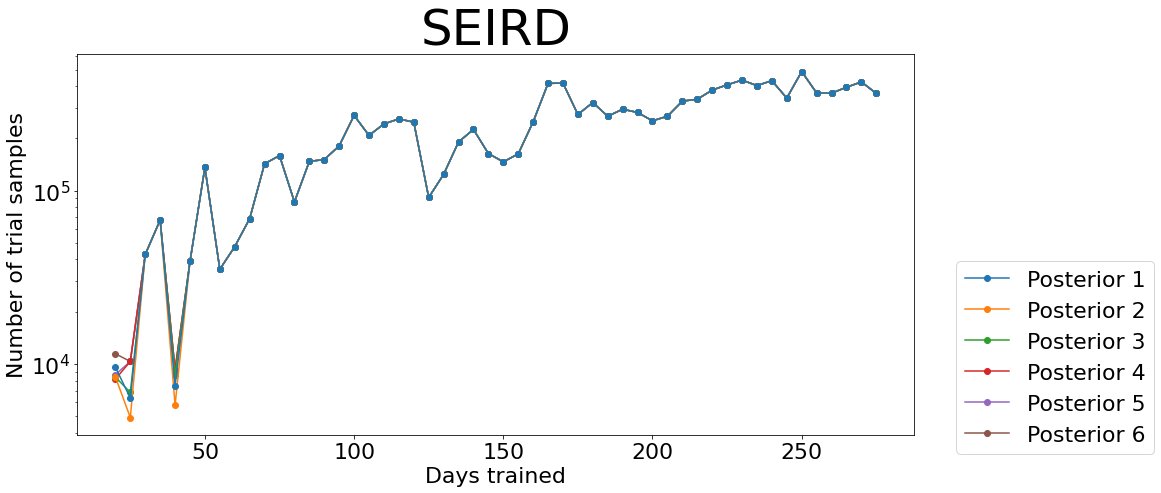

In [24]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,7))
        
    for j in range(trials.shape[1]):
            
        plt.plot(days, trials[model_idx, j], "-o", label="Posterior %i"%(j+1), zorder=-j)
        plt.legend(loc=(1.05, -0.05))
        plt.xlabel("Days trained")
        plt.ylabel("Number of trial samples")
        plt.yscale("log")
        plt.title(model.plot_name, fontsize=50)
            
    plt.show()

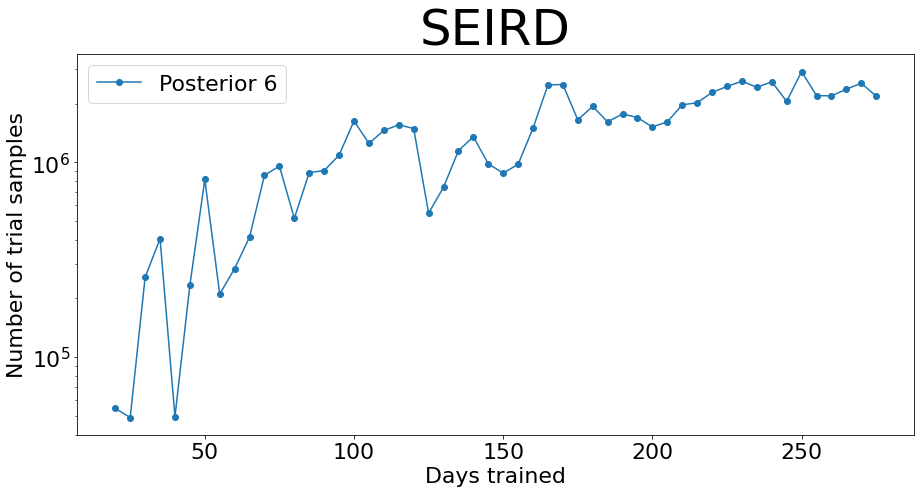

In [25]:
for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(15,7))
           
    plt.plot(days, np.sum(trials[model_idx], axis=0), "-o", label="Posterior %i"%(n_post))
    plt.legend()
    plt.xlabel("Days trained")
    plt.ylabel("Number of trial samples")
    plt.yscale("log")
    plt.title(model.plot_name, fontsize=50)
            
    plt.show()

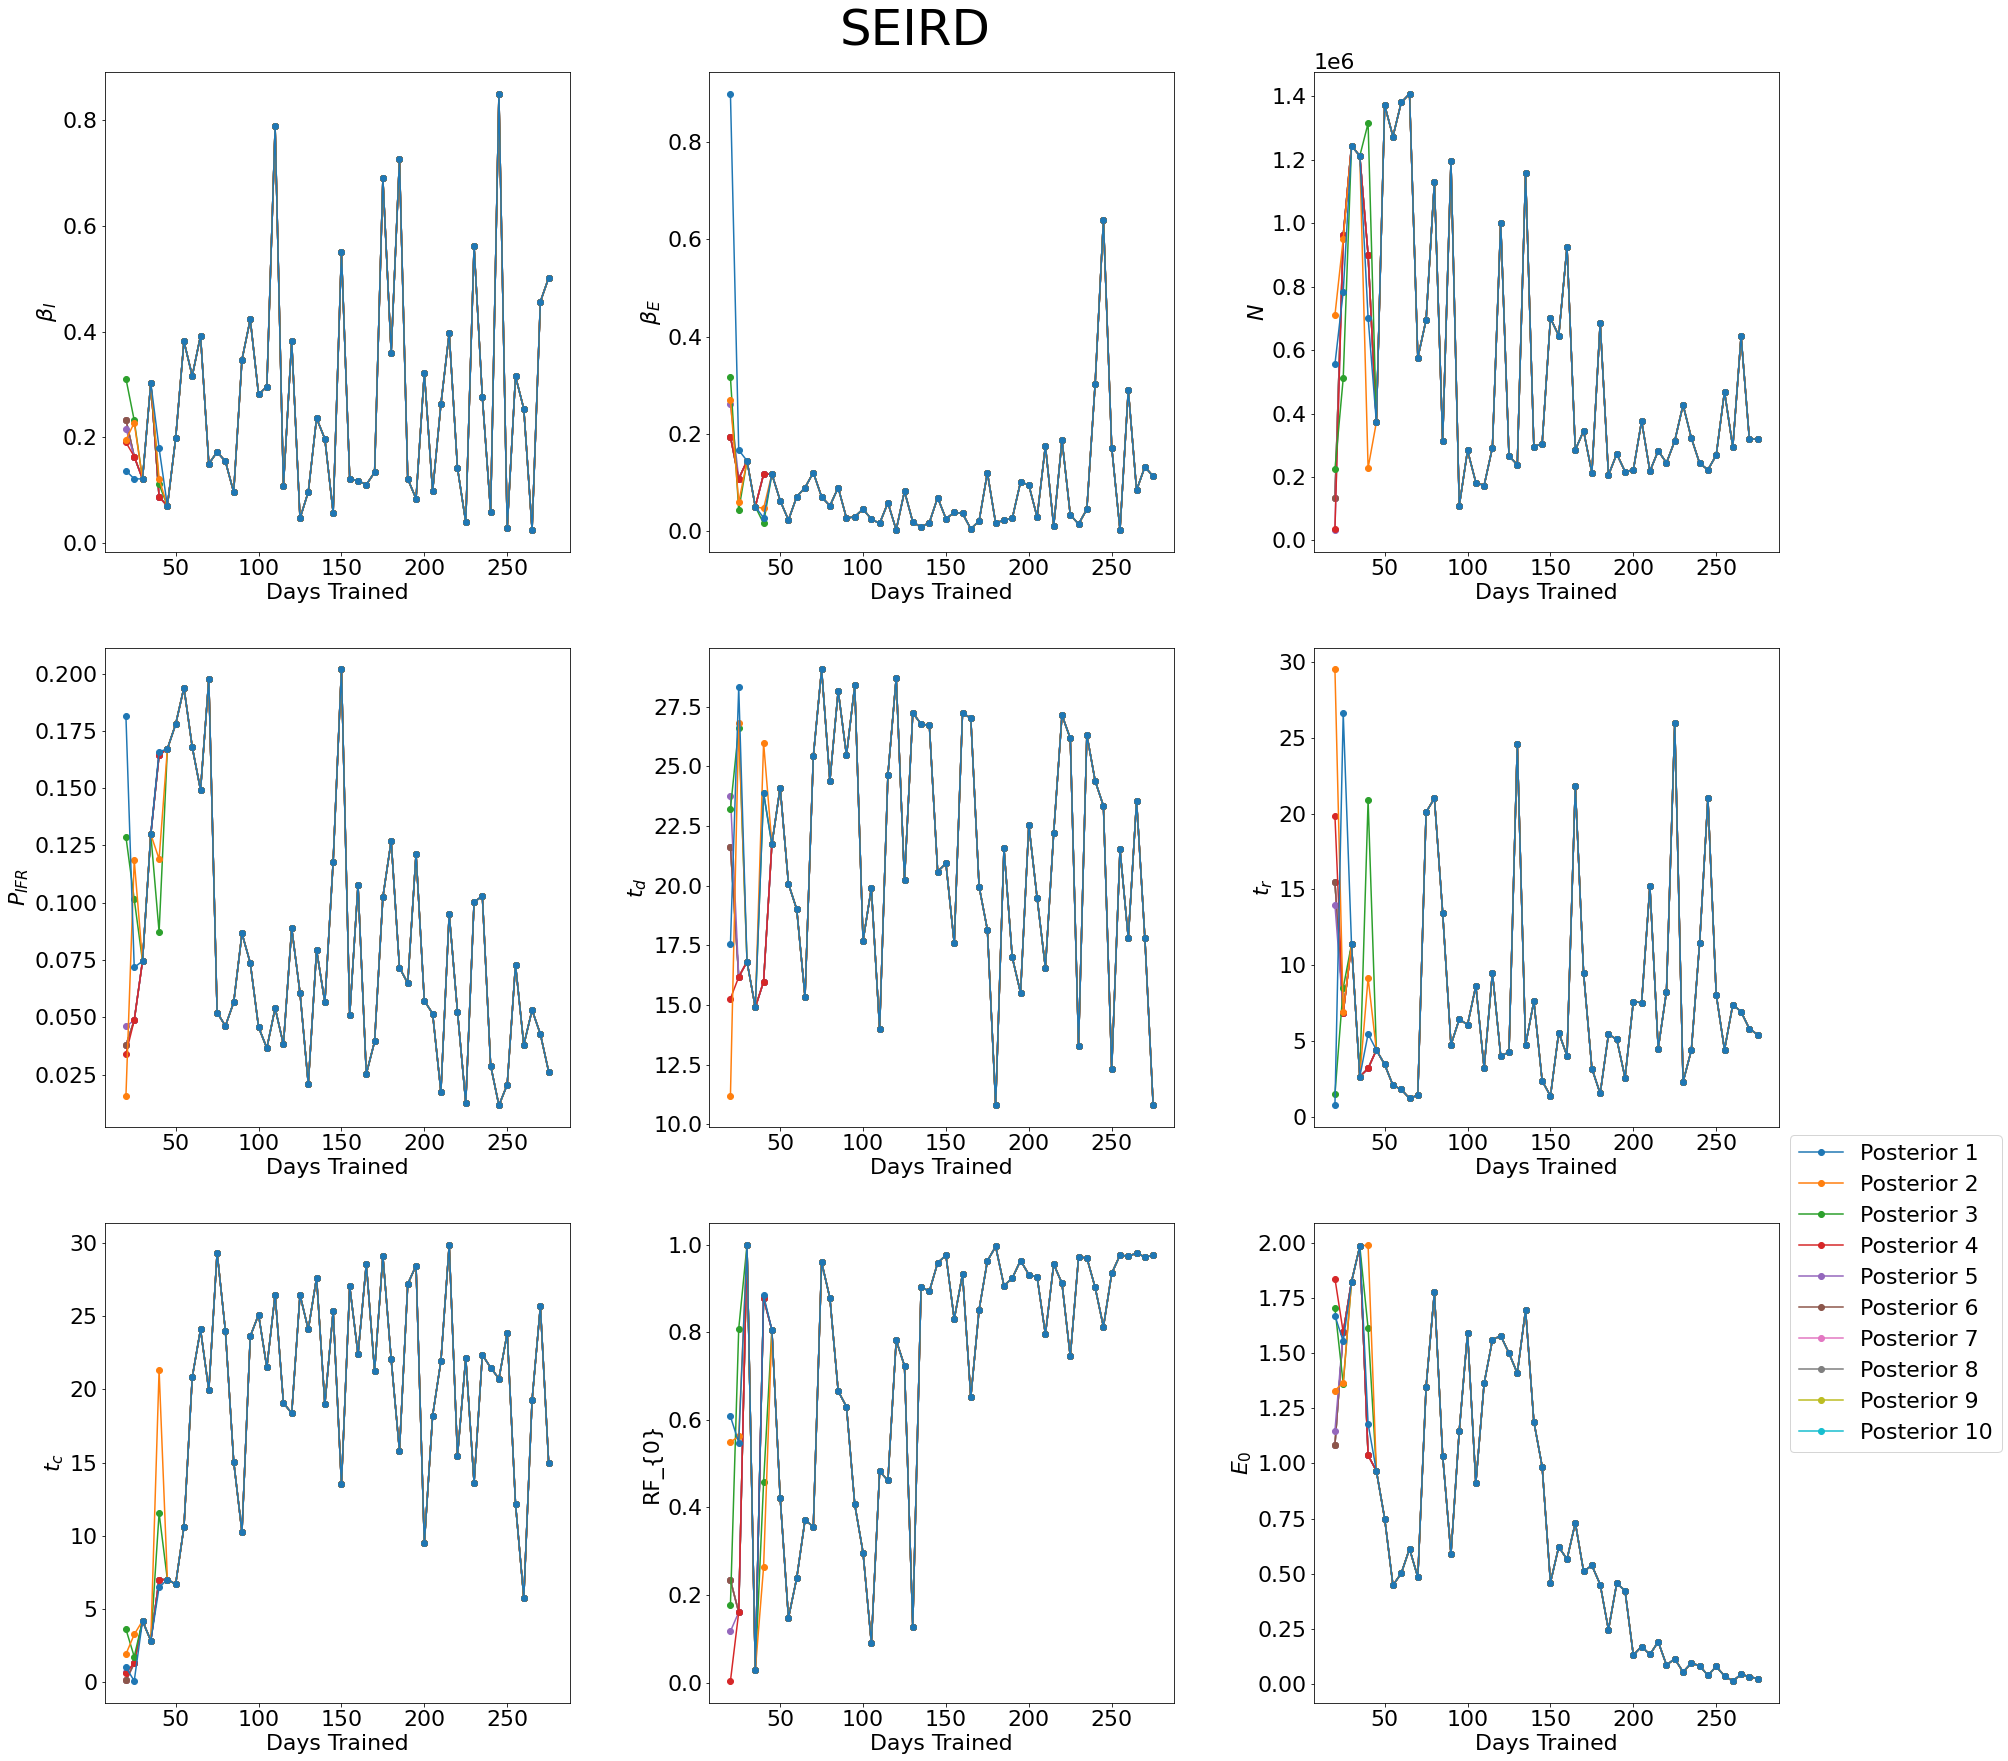

In [26]:
for p in range(len(params)):
    
    model = getattr(epi_mod, models[p])
    
    plt.figure(figsize=(10*best_rows_cols(params[p].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    
    for i in range(params[p].shape[-1]):

        plt.subplot(*best_rows_cols(params[p].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
        for j in range(params[p].shape[0]):
            plt.plot(days, params[p][j,:,i], "-o", label="Posterior %i"%(j+1), zorder=-j)
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):
            
            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")
    
    plt.suptitle(model.plot_name, fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

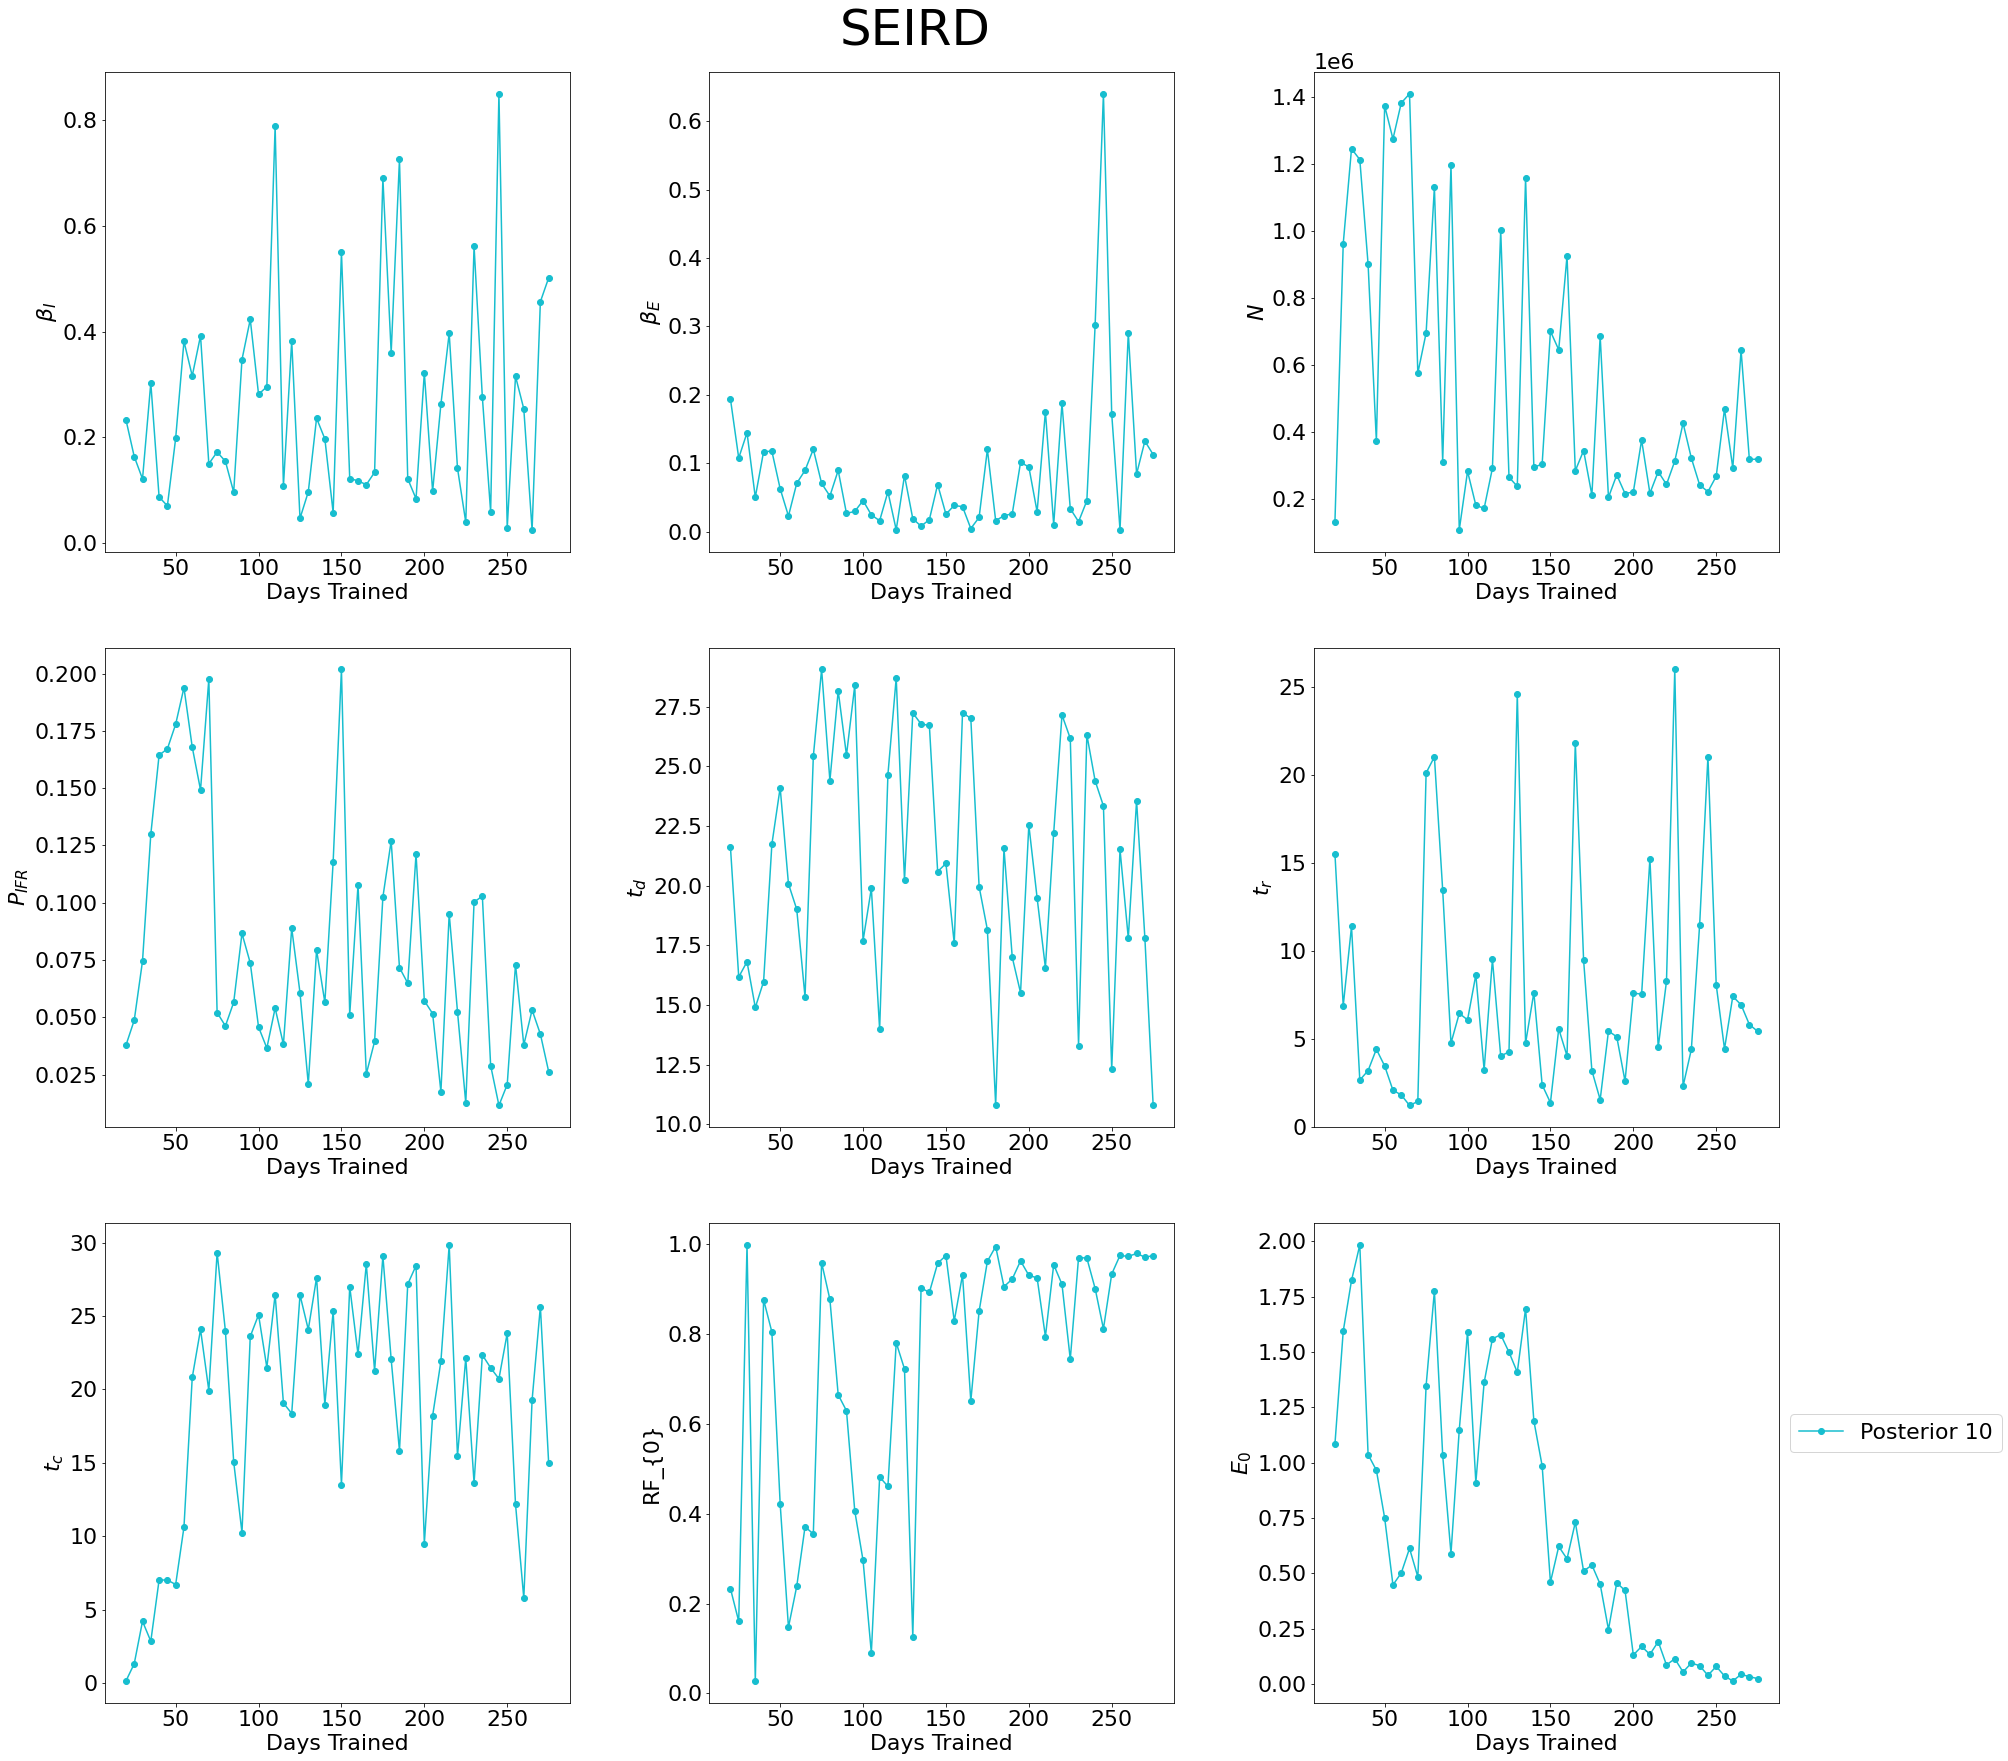

In [27]:
for p in range(len(params)):
    
    model = getattr(epi_mod, models[p])
    
    plt.figure(figsize=(10*best_rows_cols(params[p].shape[-1])[::-1]))
    plt.subplots_adjust(wspace=0.3, hspace=0.2)
    
    for i in range(params[p].shape[-1]):

        plt.subplot(*best_rows_cols(params[p].shape[-1]),i+1)
#         plt.figure(figsize=(15,7))
        plt.plot(days, params[p][-1,:,i], "-o", c="C%s"%(params[p].shape[0]-1), label="Posterior %i"%(params[p].shape[0]))
        plt.xlabel("Days Trained")
        plt.ylabel(model.params[i])

        if (i == params[p].shape[-1]-1):
            
            plt.legend(bbox_to_anchor=(1, 0.5), loc="lower left")
    
    plt.suptitle(model.plot_name, fontsize=50, y=0.91)
#     plt.savefig("params_evolution_%s.png"%(models[p]), format="png", dpi=300, bbox_inches=None)
    plt.show()

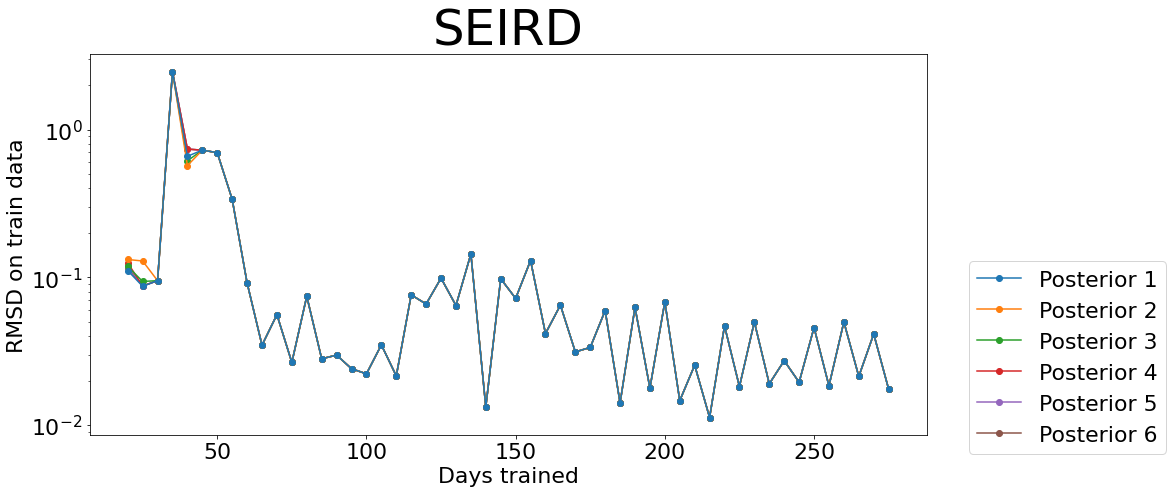

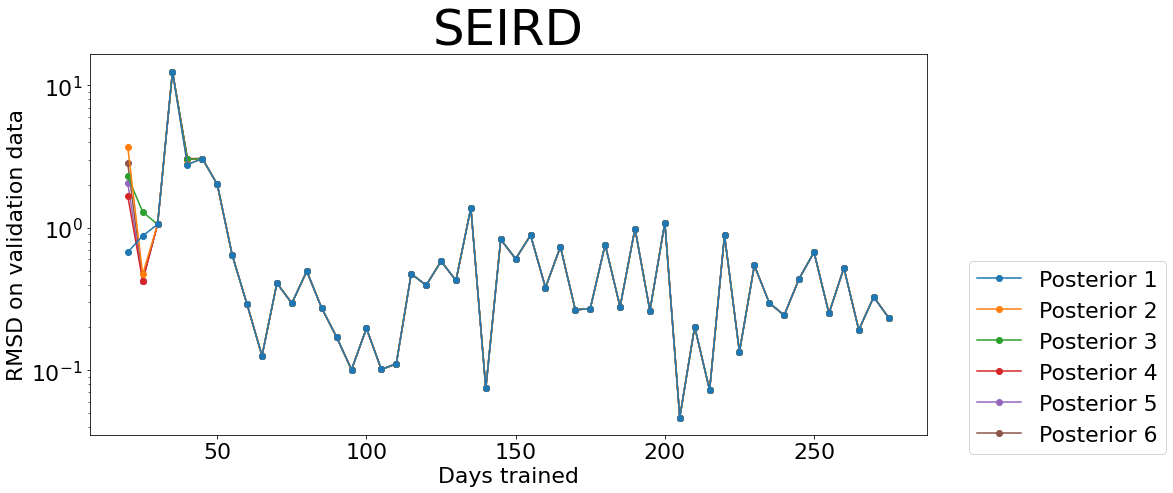

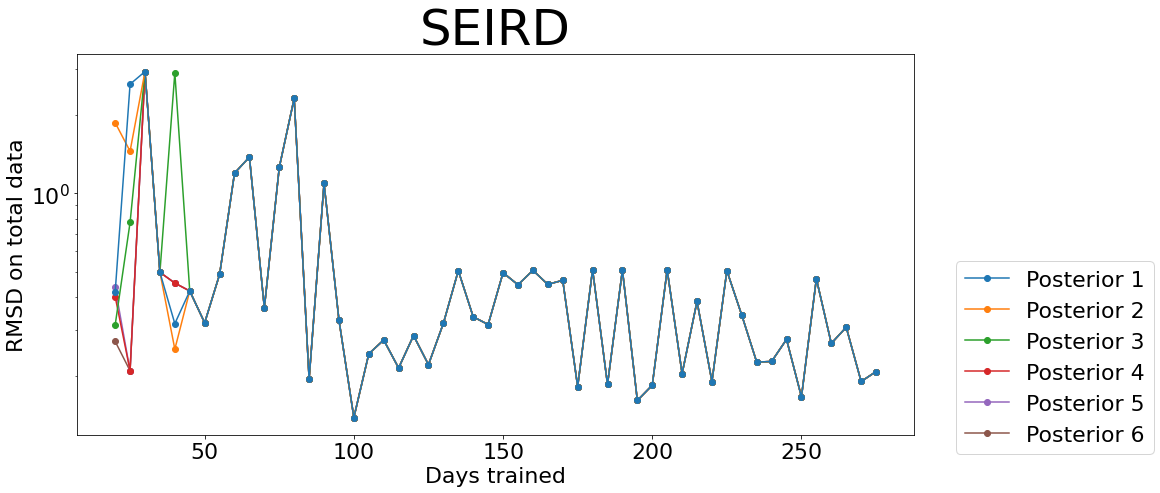

In [28]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        
        for j in range(rmsd[i].shape[1]):
            
            plt.plot(days, rmsd[i][model_idx, j], "-o", label="Posterior %i"%(j+1), zorder=-j)
            plt.legend(loc=(1.05, -0.05))
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.yscale("log")
            plt.title(model.plot_name, fontsize=50)
    plt.show()

In [29]:
rmsd_train = np.zeros((len(models), n_post, n_days))
rmsd_val= np.zeros((len(models), n_post, n_days))
rmsd_total = np.zeros((len(models), n_post, n_days))

post_size = np.zeros((len(models), n_days))
last_post = np.zeros((len(models), n_days))

params = []

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    params.append(np.zeros((n_post, n_days, model.nparams)))
        
    for post in range(1, n_post+1):
            
        path = log_path+"Posterior%i/%s/%s/" % (post, location, models[model_idx])
        
        for days_idx in range(len(days_sets)):
            
            params[-1][post-1,days_idx,:] = np.genfromtxt(path+days_sets[days_idx]+"/best_params.txt")
            
            log_file = open(path+days_sets[days_idx]+"/%s_log.out"%model.name).read().split("\n")[:-1]
            
            for line in range(len(log_file)):

                if "RMSD:" in log_file[line]:
                    rmsd_start_line = line
                    
                if "Training window size:" in log_file[line] and post == 1:
                    post_size[model_idx, days_idx] = np.int(log_file[line].split(" ")[-1])
                
                if "Posterior No." in log_file[line] and post == n_post:
                    last_post[model_idx, days_idx] = np.int(log_file[line].split(" ")[-1])
            
            rmsd_train[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line].split(" ")[-1])
            rmsd_val[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+1].split(" ")[-1])
            rmsd_total[model_idx, post-1, days_idx] = float(log_file[rmsd_start_line+2].split(" ")[-1])

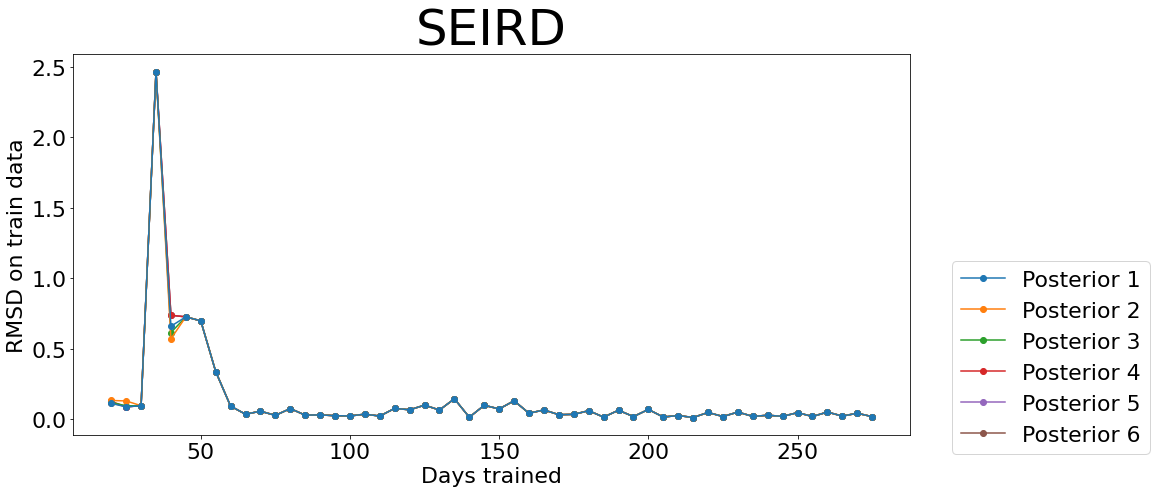

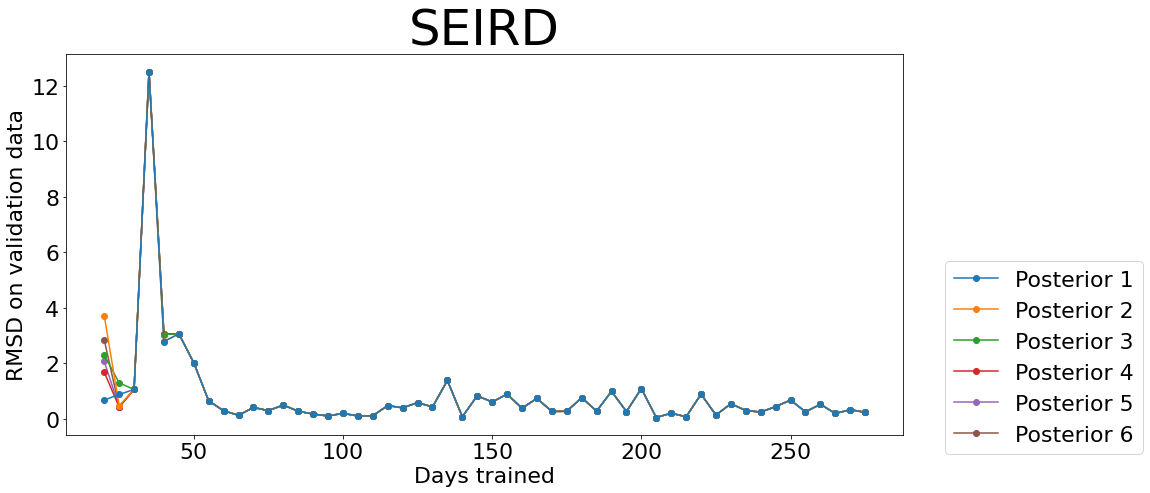

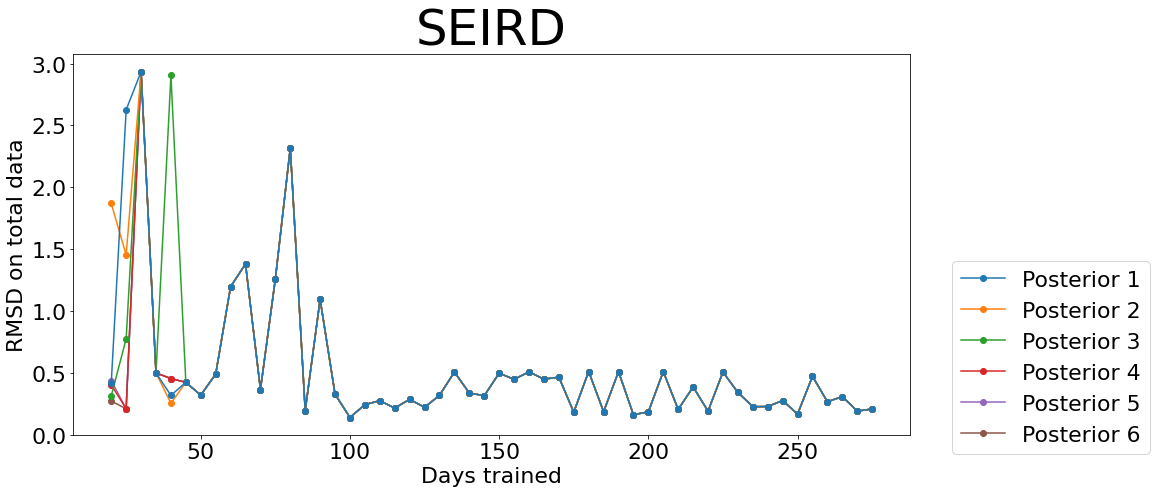

In [30]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        
        for j in range(rmsd[i].shape[1]):
            
            plt.plot(days, rmsd[i][model_idx, j], "-o", label="Posterior %i"%(j+1), zorder=-j)
            plt.legend(loc=(1.05, -0.05))
            plt.xlabel("Days trained")
            plt.ylabel(rmsd_names[i])
            plt.title(model.plot_name, fontsize=50)
    plt.show()

(0.0, 7.0)

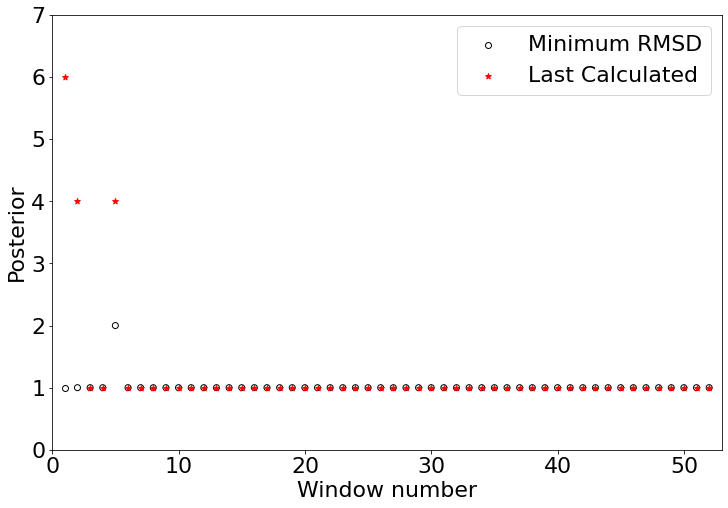

In [31]:
plt.figure(figsize=(12,8))
for i in range(rmsd_train.shape[2]):
    if i == 0:
        plt.scatter(i+1, 1+np.where(rmsd_train[0,:,i] == np.min(rmsd_train[0,:,i]))[0][0], facecolors="w", edgecolors="k", label="Minimum RMSD")
    else:
        plt.scatter(i+1, 1+np.where(rmsd_train[0,:,i] == np.min(rmsd_train[0,:,i]))[0][0], facecolors="none", edgecolors="k")
plt.scatter(np.arange(1, len(last_post[0])+1), last_post[0], marker="*", facecolors="r", edgecolors="r", label="Last Calculated")
plt.legend()
plt.xlabel("Window number")
plt.ylabel("Posterior")
plt.xlim(0, len(last_post[0])+1)
plt.ylim(0, np.max(last_post[0])+1)

In [32]:
rmsd_train[0,:,7]

array([0.337743, 0.337743, 0.337743, 0.337743, 0.337743, 0.337743])

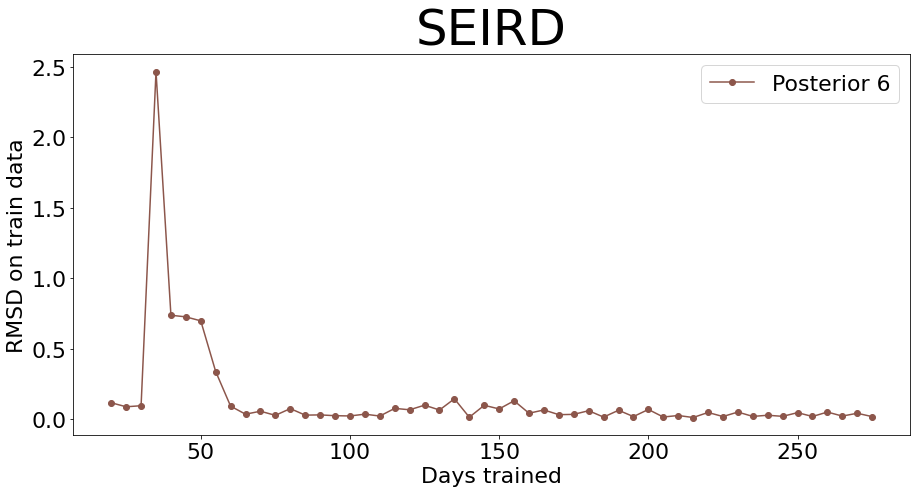

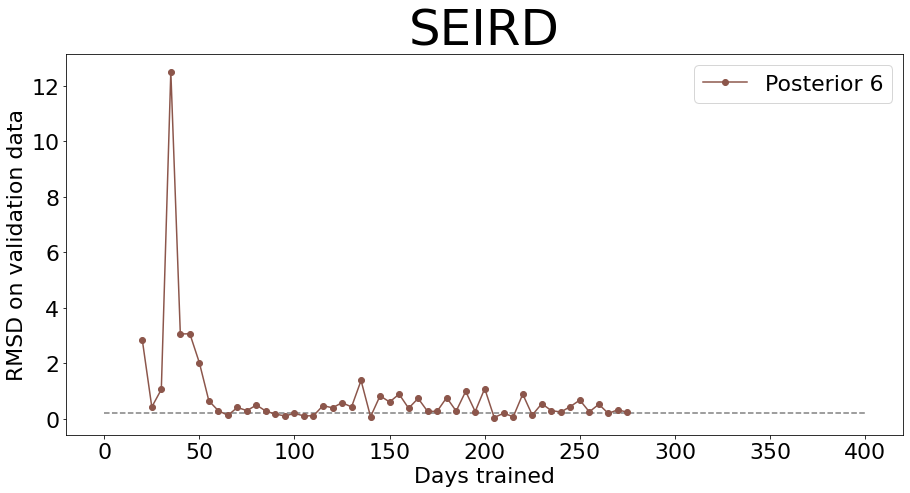

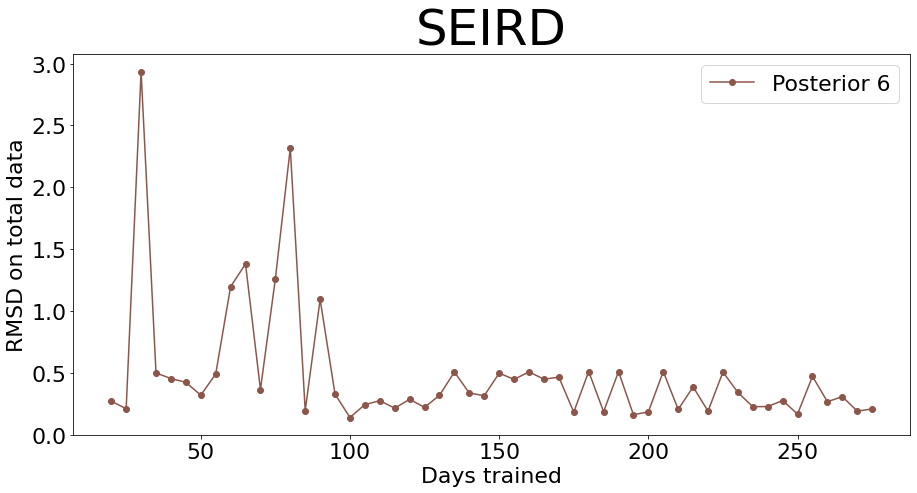

In [33]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    for i in range(len(rmsd)):
        
        plt.figure(figsize=(15,7))
        plt.plot(days, rmsd[i][model_idx, j], "-o", c="C%s"%(rmsd[i].shape[1]-1), label="Posterior %i"%(j+1))
        if i == 1:
            plt.hlines(0.2, 0, 400, color="gray", ls="--")
        plt.legend()
        plt.xlabel("Days trained")
        plt.ylabel(rmsd_names[i])
        plt.title(model.plot_name, fontsize=50)
        
    plt.show()

[4.86186718]
[4.94223995]
[4.93098911]
[4.8582074]
[4.86378934]
[4.8746838]


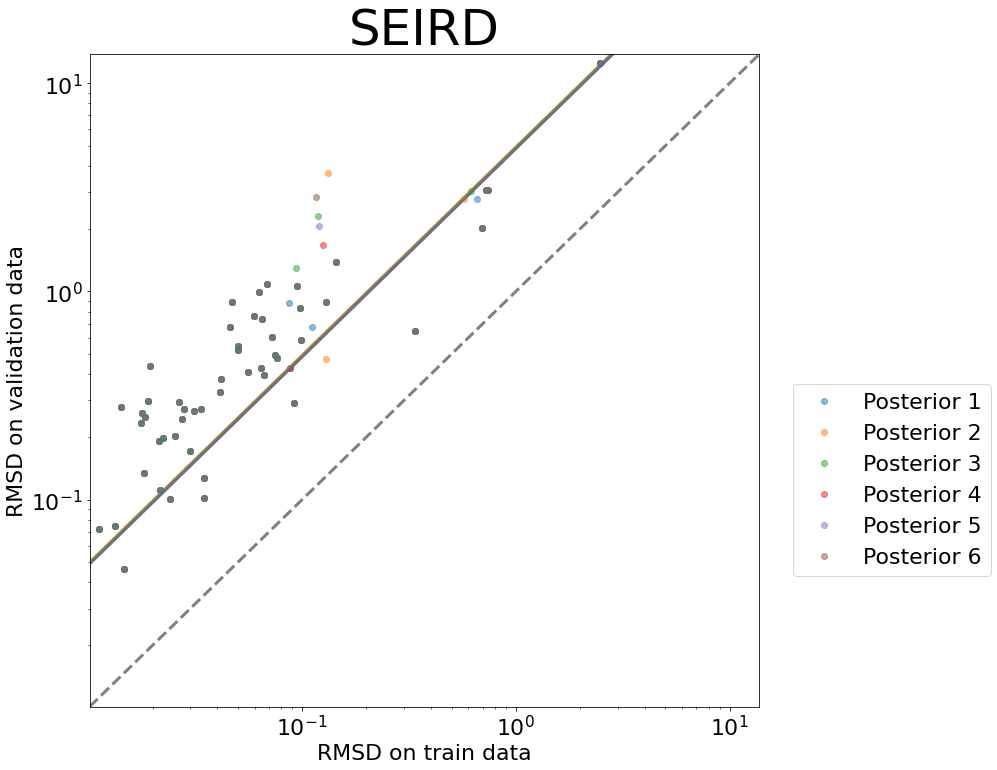

In [34]:
# plt.subplots_adjust(wspace=0.4, hspace=0.2)

rmsd = [rmsd_train, rmsd_val, rmsd_total]
rmsd_names = ["RMSD on train data", "RMSD on validation data", "RMSD on total data"]

def line(x, a):
    
    return a*x

styles = ["--", "-.", ":"]

for model_idx in range(len(models)):
    
    model = getattr(epi_mod, models[model_idx])
    
    plt.figure(figsize=(12,12))
    
    x = np.linspace(min(np.min(rmsd[0][model_idx]), np.min(rmsd[1][model_idx]))*0.9, max(np.max(rmsd[0][model_idx]), np.max(rmsd[1][model_idx]))*1.1, 2)
    plt.plot(x, x, c="gray", ls="--", lw=3)
    
    for j in range(rmsd[0].shape[1]):
        
        plt.plot(rmsd[0][model_idx, j], rmsd[1][model_idx, j], "o", label="Posterior %i"%(j+1), alpha=0.5, zorder=-j)
        p = curve_fit(line, rmsd[0][model_idx, j], rmsd[1][model_idx, j])[0]
        print(p)
        plt.plot(x, line(x, p), c=f"C{j}", lw=3, alpha=0.5, zorder=-j)
        plt.xscale("log")
        plt.yscale("log")
        plt.legend(loc=(1.05, 0.2))
        plt.xlabel(rmsd_names[0])
        plt.ylabel(rmsd_names[1])
        plt.xlim(x[0], x[-1])
        plt.ylim(x[0], x[-1])
        plt.title(model.plot_name, fontsize=50)
    plt.show()

In [35]:
from scipy.stats import pearsonr

print("RMSD on train and validation Pearson Correlations:")
for i in range(0, n_post):
    print("Posterior %i:"%(i+1), pearsonr(rmsd[0][0,i], rmsd[1][0,i]))

RMSD on train and validation Pearson Correlations:
Posterior 1: (0.9790402926200956, 3.1997698631225076e-36)
Posterior 2: (0.9545608052658519, 6.048741029358924e-28)
Posterior 3: (0.9713866975413097, 7.012758059182957e-33)
Posterior 4: (0.9764948564743939, 5.453466686270787e-35)
Posterior 5: (0.9736190237097426, 9.446953099526046e-34)
Posterior 6: (0.9654191435862374, 7.451333169774064e-31)
